In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from definitions import ROOT_DIR
from unc.utils import load_info

In [44]:
r_path = Path(ROOT_DIR, 'results', 'r')
rpg_path = Path(ROOT_DIR, 'results', 'rpg')
rsg_path = Path(ROOT_DIR, 'results', 'rsg')

split_by = ['buffer_size', 'algo']

r_color = 'black'
rsg_color = 'darkorange'
rpg_color = 'forestgreen'


def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [7]:
r_infos = [load_info(f) for f in r_path.iterdir()]

In [21]:
r_infos[0]['episode_reward'].shape, 0.99 ** r_infos[0]['episode_length']

((10606,),
 array([9.50990050e-01, 9.22744694e-01, 9.41480149e-01, ...,
        9.60596010e-01, 9.70299000e-01, 4.31712474e-05]))

In [66]:
def process_dir(dir_path, w=100, split_by=None, discount=0.99):
    if split_by is not None:
        all_results = {}
    else:
        all_results = []
        
    for f in dir_path.iterdir():
        info = load_info(f)
        args = info['args'].item()
        
        # We only consider prefilled here
        if args['p_prefilled'] == 0.:
            continue
        
        result = info['episode_reward'] * (discount ** info['episode_length'])

        if split_by is not None:
            hparams = tuple(args[s] for s in split_by)
            split_by_tuple = tuple(split_by)
            if split_by_tuple not in all_results:
                all_results[split_by_tuple] = {}
            
            if hparams not in all_results[split_by_tuple]:
                all_results[split_by_tuple][hparams] = []
                
            all_results[split_by_tuple][hparams].append((info['episode_length'], result))
            
        else:
            all_results.append((info['episode_length'], result))
            
#     if split_by is not None:
#         for k, v in all_results.items():
#             for k1, v1 in v.items():
#                 all_results[k][k1] = np.array(all_results[k][k1])
#         data = all_results
#     else:
#         data = np.array(all_results)

    
    return all_results


In [67]:
discount = 0.99
r_data = process_dir(r_path, split_by=split_by, discount=discount)
rpg_data = process_dir(rpg_path, split_by=split_by, discount=discount)
rsg_data = process_dir(rsg_path, split_by=split_by, discount=discount)

In [71]:
r_data

{('buffer_size',
  'algo'): {(100000,
   'sarsa'): [(array([392,   2,   2, ...,   8,   9, 236]),
    array([0.19453434, 9.801     , 9.801     , ..., 9.22744694, 9.13517247,
           2.7991565 ])), (array([33,  8,  9, ..., 21, 30, 41]),
    array([ 7.17730533,  9.22744694,  9.13517247, ...,  8.09727868,
            7.39700373, 19.86846123])), (array([  3, 116,   3, ...,   1, 185,  32]),
    array([ 9.70299   ,  3.11661081,  9.70299   , ...,  9.9       ,
            1.55779749, 21.74941008])), (array([181,   1,   6, ...,   1,   2, 163]),
    array([-8.1084945 ,  9.9       ,  9.41480149, ...,  9.9       ,
            9.801     , -1.94328599])), (array([130,   6,  17, ..., 191,   3, 201]),
    array([2.7075426 , 9.41480149, 8.42943193, ..., 2.93327083, 9.70299   ,
           0.        ])), (array([271,   1,  71, ...,  12,   2, 302]),
    array([ 0.65635339,  9.9       ,  9.79780546, ..., 17.72769743,
            9.801     ,  1.44194941])), (array([110,   1,   6, ...,   1,   7, 122]),
   

In [77]:
# we average the discounted episodic rewards over the final 100 episodes.

def get_eps_max_over(data, eps_max_over=100):
    hparam_results = []
    for args, all_dis_rew in data[tuple(split_by)].items():
        final_max = np.mean([np.mean(dis_rew[-100:]) for length, dis_rew in all_dis_rew])
        hparam_results.append((args, final_max))
    return hparam_results


In [79]:
eps_max_over = 100
r_max_over = get_eps_max_over(r_data, eps_max_over)
rpg_max_over = get_eps_max_over(rpg_data, eps_max_over)
rsg_max_over = get_eps_max_over(rsg_data, eps_max_over)

In [80]:
# Get the best hyperparams based on the final 100 episodes
r_best = sorted(r_max_over, key=lambda x : x[1], reverse=True)[0]
rpg_best = sorted(rpg_max_over, key=lambda x : x[1], reverse=True)[0]
rsg_best = sorted(rsg_max_over, key=lambda x : x[1], reverse=True)[0]

r_best, rpg_best, rsg_best

(((100000, 'sarsa'), 8.600177871073088),
 ((50000, 'sarsa'), 23.31618104455116),
 ((100000, 'sarsa'), 34.55754850133997))

In [115]:
# Now we map our discounted episodic rewards back to steps. We assign the discounted reward achieved at the 
# end of and episode to each timestep within the episode


def map_dis_rew_to_steps(data, w=1000):
    all_seeds = []
    for lengths, dis_rews in data:
        current_seed = []
        for length, dis_rew in zip(lengths, dis_rews):
            current_seed.append(np.zeros(length) + dis_rew)
        all_seeds.append(moving_avg(np.concatenate(current_seed)[:trunc], w=w))
    return np.array(all_seeds)

In [116]:
trunc = int(5e5)

r_best_data = r_data[tuple(split_by)][r_best[0]]
rpg_best_data = rpg_data[tuple(split_by)][rpg_best[0]]
rsg_best_data = rsg_data[tuple(split_by)][rsg_best[0]]

mapped_r = map_dis_rew_to_steps(r_best_data)
mapped_rpg = map_dis_rew_to_steps(rpg_best_data)
mapped_rsg = map_dis_rew_to_steps(rsg_best_data)

In [117]:
all_data = [
    ('Normal obs', mapped_r, r_color),
    ('PF obs', mapped_rpg, rpg_color),
    ('Ground-truth obs', mapped_rsg, rsg_color)
]

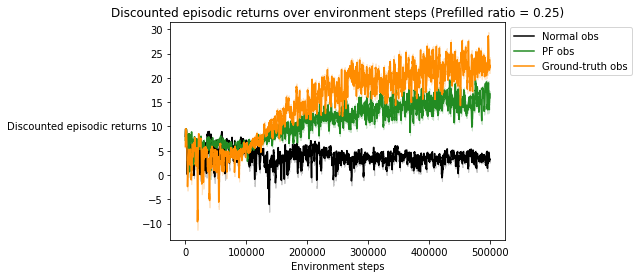

In [121]:
x = np.arange(mapped_r.shape[1])
fig, ax = plt.figure(), plt.axes()


for key, data, color in all_data:
    means = data.mean(axis=0)
    std_err = data.std(axis=0) / data.shape[0]

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Discounted episodic returns", rotation=0, labelpad=65)
ax.set_title(f'Discounted episodic returns over environment steps (Prefilled ratio = 0.25)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')
